Import the required libraries

In [1]:
from jupyter_core.paths import jupyter_path

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb # Our ML library

In [3]:
#We will run the normal distribution test with
from scipy.stats import shapiro

In [4]:
#Can help with the visualization
import matplotlib.gridspec as gridspec
import SeabornFig2Grid as sfg

Read all CSVs with stocks data and append to one big file

In [5]:
#os.chdir("/Users/olegkazanskyi/Documents/GitHub/Trading/CSVs")
os.chdir("C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading Python/DOW30_CSVs_042022")
filepaths = [f for f in os.listdir("./") if f.endswith('.csv')]
df = pd.DataFrame()
for i in filepaths:
    iterate_df = pd.DataFrame()
    iterate_df = pd.read_csv(i)
    iterate_df["stock"] = i[:-4]
    df = pd.concat([df,iterate_df])
#df = pd.concat(map(pd.read_csv, filepaths))

#os.chdir("/Users/olegkazanskyi/Documents/GitHub/Trading")
os.chdir("C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading Python")

Let's keep only KPI type columns that we initially considered as the most important

In [6]:
df = df[["date","roe", "longTermDebtEquity", "grossMargin", "revenueQoQ", "epsQoQ", "piotroskiFScore", "currentRatio", "roa", "profitMargin","peRatio", "pbRatio","trailingPEG1Y","VIX_high","sector","industry","10Y_bonds", "10Y_bond_MoM","Debt-to-Equity_Ratio","DividendsYield","PayoutRatio","Acc_Rec_Pay_Ration","Earnings_per_stock","dividends_change","prev_div_change","days_after_divid_report","surprise_%", "expected_growth", "previous_surprise","days_after_earn_report","future_30dprice_change","stock"]]

Set up Date column as an index columns

In [7]:
df.set_index(["date"], inplace = True)

The column future_30dprice_change is our target column
 
 We do not need rows with nan values there

In [8]:
df = df[df.future_30dprice_change.notna()]

Let's check how much empty values we have by column

In [9]:
#df_compact.to_csv("all_stocks.csv")

In [10]:
df.isnull().sum()

roe                           0
longTermDebtEquity            0
grossMargin                   0
revenueQoQ                    0
epsQoQ                        0
piotroskiFScore               0
currentRatio               2848
roa                           0
profitMargin                  0
peRatio                       0
pbRatio                       0
trailingPEG1Y                 0
VIX_high                      0
sector                        0
industry                      0
10Y_bonds                     0
10Y_bond_MoM                660
Debt-to-Equity_Ratio          0
DividendsYield                0
PayoutRatio                   0
Acc_Rec_Pay_Ration            0
Earnings_per_stock            0
dividends_change            691
prev_div_change             691
days_after_divid_report     691
surprise_%                   81
expected_growth              81
previous_surprise           146
days_after_earn_report       81
future_30dprice_change        0
stock                         0
dtype: i

In [11]:
categoric_columns = df.select_dtypes(include='object').columns
for col in categoric_columns:
    if col == "date":
        continue
    print(f"column {col}, data: \n {df[col].unique()}")

column sector, data: 
 ['Technology' 'Healthcare' 'Financial Services' 'Industrials' 'Energy'
 'Consumer Cyclical' 'Basic Materials' 'Consumer Defensive'
 'Communication Services']
column industry, data: 
 ['Consumer Electronics' 'Drug Manufacturers - General' 'Credit Services'
 'Aerospace & Defense' 'Farm & Heavy Construction Machinery'
 'Software - Application' 'Communication Equipment' 'Oil & Gas Integrated'
 'Entertainment' 'Chemicals' 'Capital Markets' 'Home Improvement Retail'
 'Specialty Industrial Machinery' 'Information Technology Services'
 'Semiconductors' 'Banks - Diversified' 'Beverages - Non-Alcoholic'
 'Restaurants' 'Software - Infrastructure' 'Footwear & Accessories'
 'Household & Personal Products' 'Insurance - Property & Casualty'
 'Healthcare Plans' 'Telecom Services' 'Pharmaceutical Retailers'
 'Discount Stores']
column stock, data: 
 ['AAPL' 'AMGN' 'AXP' 'BA' 'CAT' 'CRM' 'CSCO' 'CVX' 'DIS' 'DOW' 'GS' 'HD'
 'HON' 'IBM' 'INTC' 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT

We can drop "Stocks" and "Industry" columns as there are too many unique values that block us from generalizing the data. 

In [12]:
df.drop(["industry"], axis = 1, inplace = True)

## Replacing null values

 There are 691 empty values related to dividends.
 
 As this dataframe consist of data from 30 companies, it shows one company in the list doesn't pay dividends.
 
 The stock is CRM
 
 We should not remove this data, it's better to replace it with 0's 
 
 as there are many companies that do not pay dividends we may analyze in future

In [13]:
df[df["dividends_change"].isna()].stock

df.dividends_change = df.dividends_change.fillna(0)
df.prev_div_change = df.prev_div_change.fillna(0)
df.days_after_divid_report = df.days_after_divid_report.fillna(0)

We can drop rows where 10Y_bond_MoM is nan. Those are the earliest days in the dataset.

 We had a limit of 1450 days of historical data creating it

In [14]:
df = df[df['10Y_bond_MoM'].notna()]

 We can also drop rows with the blank previous surprise. 

We are not loosing much data and it is related to limit of historical numbers in calculations

In [15]:
df = df[df['previous_surprise'].notna()]

 Now we can deal with CurrentRatio

First let's replace nan by mean

 for several stocks currentRatio is not available.
 
 This KPI shows short term debt to cash ratio
 
 We should not remove it as we will loose data for a full stock. 
Let's replace it with average values

In [16]:
df.loc[:,'currentRatio'] = df.loc[:,'currentRatio'].fillna(df.groupby('sector')['currentRatio'].transform('mean'))

Let's save mean values by catefory for future reference, if we need to build a pipeline

In [17]:
curr_ratio_mean_val = df.groupby('sector', as_index=False)['currentRatio'].mean()

## Trimming the data to avoid overfitting

 Our dataset have the range of dates that are very close to each other. 

The changes in trading value are rarely very different between today and yesterday. 

There are exemptions but mostly these are connected with big surprises, and in any case we would notice the change even if we track every other day or every 4th day.

It means that removing part of the dataset should help us in building more generalized model since we will be looking for trend but not for matching values.


Let's do this, let's remove 4/5 of the dataset.

That means we will keep only one day of data per week. It will help us to generalize the dataset

In [18]:
print("Old dataframe shape:", df.shape)
df_compact = df.iloc[::5, :]
print("New dataframe shape:", df_compact.shape)

Old dataframe shape: (20345, 30)
New dataframe shape: (4069, 30)


Now we can split our dataset to train and test to avoid further contamination

In [19]:
df_train, df_test = train_test_split(df_compact, test_size=0.2, random_state=42)

Now let's use the same values from training data to test data

In [20]:
'''list_of_stocks_empty_ratio = df_test[df_test["currentRatio"].isna()].stock.unique()
for paper in list_of_stocks_empty_ratio:
    df_test.loc[df_test.stock == paper,'currentRatio'] = df_train[df_train.stock == paper]['currentRatio'].mean()'''

'list_of_stocks_empty_ratio = df_test[df_test["currentRatio"].isna()].stock.unique()\nfor paper in list_of_stocks_empty_ratio:\n    df_test.loc[df_test.stock == paper,\'currentRatio\'] = df_train[df_train.stock == paper][\'currentRatio\'].mean()'

## Dealing with highly correlated variables

Find the highly correlated columns so we can remove those

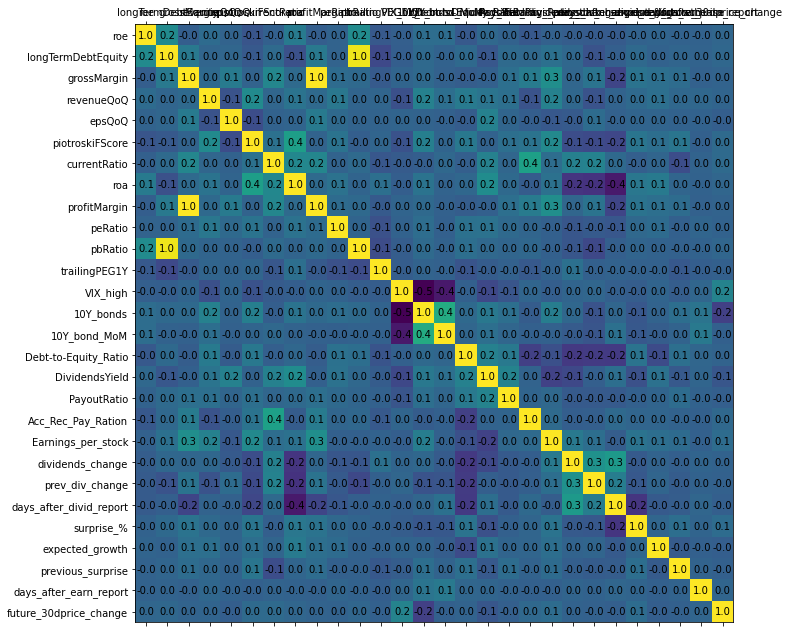

In [21]:
def plot_corr(df, size=11):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
plot_corr(df_train)

 We have 4 columns with correlation higher 0.95
 
-  longTermDebtEquity correlates with pbRatio
 
-  grossMargin correlates with profitMargin
 
 out of definition of those we understand that they are very close and we can drop those

In [22]:
df_train.drop(["longTermDebtEquity","grossMargin"], axis = 1, inplace = True)
df_test.drop(["longTermDebtEquity","grossMargin"], axis = 1, inplace = True)

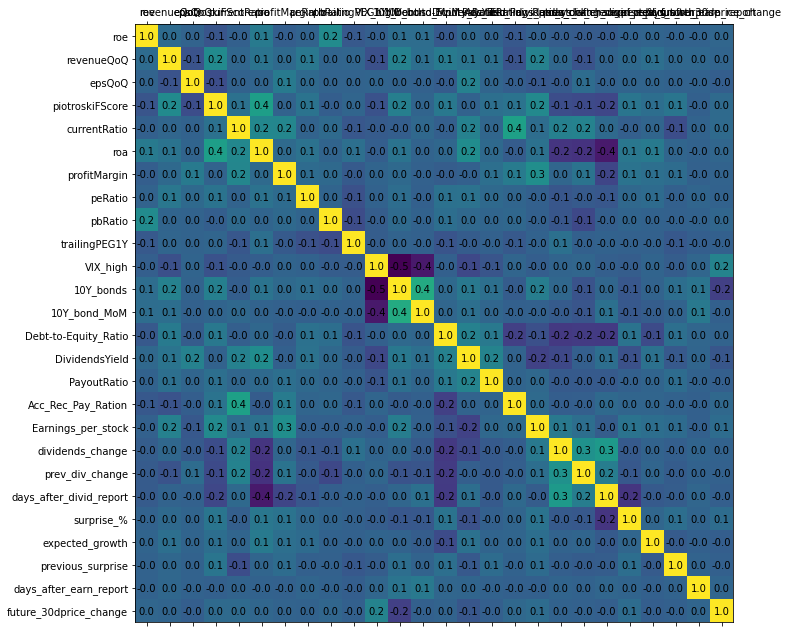

In [23]:
plot_corr(df_train)

 Let's check if there are variables with correlation above 0.5

In [24]:
def check_corr(dataframe, max_corr = 0.4):
    corr= dataframe.corr().replace(1,np.nan)
    #corr = corr[corr>0.5]
    columns_vertical = dataframe.select_dtypes([np.number]).columns
    columns_horisontal = dataframe.select_dtypes([np.number]).columns
    for column_a in columns_vertical:
        for column_b in columns_horisontal:
            corr_minor = dataframe[column_a].corr(dataframe[column_b])
            corr_minor_digits = "{:.2f}".format(corr_minor)
            if corr_minor>max_corr and column_b != column_a:
                print(f"column {column_a} correlates with {column_b} : {corr_minor_digits}")
                
check_corr(df_train, 0.4)

column 10Y_bonds correlates with 10Y_bond_MoM : 0.43
column 10Y_bond_MoM correlates with 10Y_bonds : 0.43


There are no columns with correlation above 0.5



## Dealing with outliers

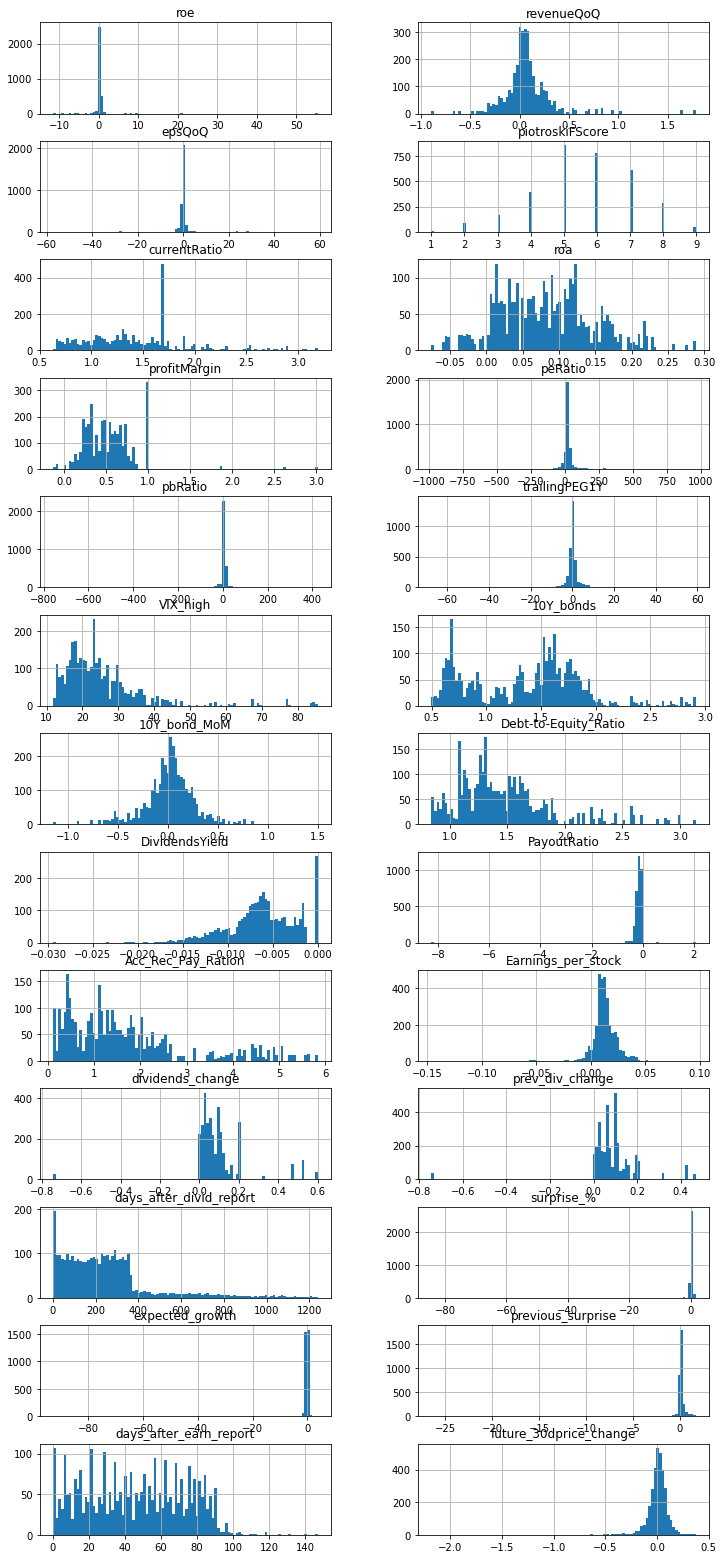

In [25]:
cols_num = df_train.select_dtypes([np.number]).columns
cols_str = df_train.select_dtypes('object').columns

df_train[cols_num].hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

Conclusions:
- The majority of DOW30 companies have Piotroski score above 5 which means they are in good financial health.
- Return on assets for the majority of companies was above 0 and below 30%. It shows that most of the time companies were profitable.
- Profit margin for the majority is under 100%. A spike of companies with a profit margin equal to 100% should be highlighted.
- 10Y bonds yield did not go above 3% for long for the specified period. 
- Companies usually inform about dividends change once a year and in general, dividends grew.
- future 30d price change looks like a normally distributed curve with the outliers on the left side and a mean value close to "0". It shows that our dataset has balanced data of stock movements up and down.

### Now we better to separate numeric columns to check the distribution and make a deeper analysis

In [26]:
df_train[cols_num].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
roe,3255.0,0.426304,3.503919,-11.606320,0.117290,0.273729,0.393331,55.337634
revenueQoQ,3255.0,0.074612,0.257502,-0.892284,-0.026103,0.049196,0.140706,1.786201
epsQoQ,3255.0,-0.207220,5.799350,-57.250000,-0.352113,0.030303,0.276596,59.000000
piotroskiFScore,3255.0,5.627957,1.508066,1.000000,5.000000,6.000000,7.000000,9.000000
currentRatio,3255.0,1.417068,0.491335,0.627138,1.061324,1.362792,1.682229,3.191438
roa,3255.0,0.082987,0.064511,-0.075248,0.032988,0.080761,0.122134,0.288626
profitMargin,3255.0,0.535482,0.309508,-0.130722,0.321204,0.493668,0.686617,3.018692
peRatio,3255.0,21.361965,76.325695,-981.900000,13.358657,20.981086,28.590841,966.800000
pbRatio,3255.0,3.521046,56.027062,-758.399493,1.985843,4.968986,8.027798,423.173345
trailingPEG1Y,3255.0,0.195650,7.144975,-67.622784,-0.552856,0.135616,0.944884,59.381177


In [27]:
print("Minimum historical date: ", df.index.min())
print("Maximum historical date: ", df.index.max())

Minimum historical date:  2019-07-02
Maximum historical date:  2022-04-26


## We can describe the most interesting details of what we see.
Within DOW30 companies for a period from July 2019 to March 2022:
- Average market Return on Equity is 38%. A value in the range of 15-20% is considered as good for a company. A standard deviation is 326%. It shows there are companies with periods of big losses (negative values) and there are companies with very low shareholder's equity (very high values)
- Average Revenue quarter-over-quarter change is +7% with 25% std. While the majority of companies are profitable there are still periods for companies with high negative revenue.
- The average expected growth (reported earnings vs future expected earnings) is -51%. At the same time, average surprise is -25% which shows that after reporting the values are lower than expected.
- Dividends on average grow 9.7% after an announcement. 50% of Companies announce dividend change every 213 days.
- On Average stocks' value increased 0.2% every 30 days.

## Categorical Data

In [28]:
print(df_train.sector.unique())
df_train[["sector","stock"]].groupby("sector").nunique()

['Technology' 'Consumer Defensive' 'Consumer Cyclical'
 'Communication Services' 'Industrials' 'Healthcare' 'Financial Services'
 'Basic Materials' 'Energy']


,stock
sector,
Basic Materials,1
Communication Services,1
Consumer Cyclical,4
Consumer Defensive,4
Energy,1
Financial Services,5
Healthcare,4
Industrials,4
Technology,6


We have 9 Sectors. Several sectors are presented only by 1 Sock.

In [29]:
df_train.groupby("sector").mean().style.highlight_max(color='green').highlight_min(color='red')

,roe,revenueQoQ,epsQoQ,piotroskiFScore,currentRatio,roa,profitMargin,peRatio,pbRatio,trailingPEG1Y,VIX_high,10Y_bonds,10Y_bond_MoM,Debt-to-Equity_Ratio,DividendsYield,PayoutRatio,Acc_Rec_Pay_Ration,Earnings_per_stock,dividends_change,prev_div_change,days_after_divid_report,surprise_%,expected_growth,previous_surprise,days_after_earn_report,future_30dprice_change
sector,,,,,,,,,,,,,,,,,,,,,,,,,,
Basic Materials,0.114863,0.163607,-8.338389,5.817204,1.659897,0.027995,0.165134,2.138475,2.675190,0.077335,26.598387,1.277699,0.033398,1.328677,-0.013551,-0.308818,1.484956,0.014417,0.521739,0.095238,712.526882,0.154492,-0.290365,0.155999,46.032258,0.022980
Communication Services,0.296538,0.008394,0.192075,5.099010,0.988303,0.061848,0.591576,12.806065,3.549956,-0.080802,24.295842,1.300564,0.022723,1.274673,-0.010862,-0.132397,1.253142,0.022381,0.023448,0.023165,175.188119,0.023896,-0.016575,0.022725,45.950495,-0.000265
Consumer Cyclical,1.385038,0.100982,0.883296,5.084633,1.538945,0.125265,0.417321,30.384296,-10.343896,3.141451,24.806303,1.353555,0.015878,1.302341,-0.003663,-0.154515,1.418498,0.006966,0.094363,0.120022,315.721604,-0.337923,-0.364313,-0.501228,44.625835,-0.000542
Consumer Defensive,0.239607,0.044427,-0.512926,6.276699,0.858134,0.068806,0.389630,25.448895,5.885269,0.220967,24.989854,1.355905,0.022633,1.479507,-0.007224,-0.165581,0.341073,0.011831,0.037588,0.039951,188.483010,0.089474,-0.072191,0.090858,45.276699,0.002322
Energy,0.021866,0.235199,-5.880902,5.777778,1.186365,0.012414,0.241907,12.733812,1.452850,0.100382,24.497593,1.397009,0.019620,2.426298,-0.012367,-0.071387,1.110218,0.008962,0.064347,0.061328,190.731481,0.059344,-9.603448,0.175761,45.490741,0.014028
Financial Services,0.187161,0.095587,0.654208,5.109290,1.678057,0.045046,0.845221,18.227788,3.938868,-1.407003,25.068179,1.350546,0.006424,1.292572,-0.005379,-0.080123,2.272176,0.019121,0.188079,0.176349,279.624772,0.197228,-0.283377,0.193794,45.978142,0.002486
Healthcare,0.377274,0.092027,0.060299,6.268456,1.284551,0.100422,0.591642,22.190028,8.735231,-0.248969,25.279754,1.368047,0.009286,1.471474,-0.006348,-0.170705,1.995625,0.012536,0.104598,0.114814,190.201342,0.090773,-0.031815,0.085551,44.501119,0.009914
Industrials,0.232400,-0.037527,-0.128611,5.251701,1.504860,0.060775,0.287548,8.230600,1.422682,-0.528193,25.105782,1.332229,0.020279,1.237494,-0.005795,-0.388715,2.365175,0.008909,0.115421,0.122030,360.231293,-2.257918,-0.132742,-0.201270,46.183673,-0.008449
Technology,0.381900,0.092656,0.308454,5.873282,1.567348,0.120484,0.669555,28.980866,9.499158,0.369594,24.917588,1.360437,0.026253,1.807936,-0.005327,-0.130757,1.672195,0.013041,0.012449,0.012237,155.818321,0.180360,-0.079775,0.175228,45.948092,0.004868


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


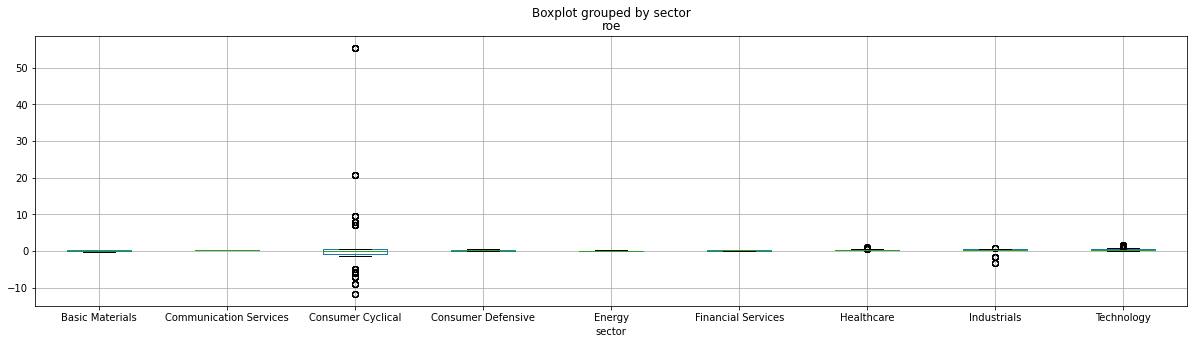

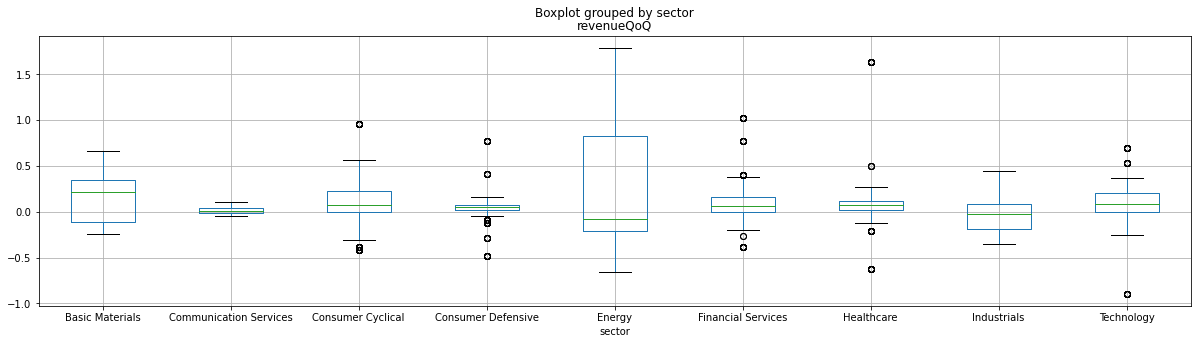

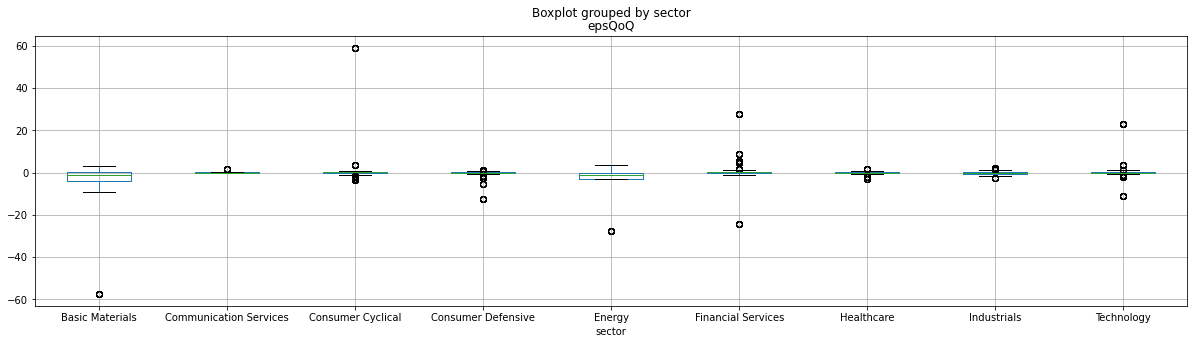

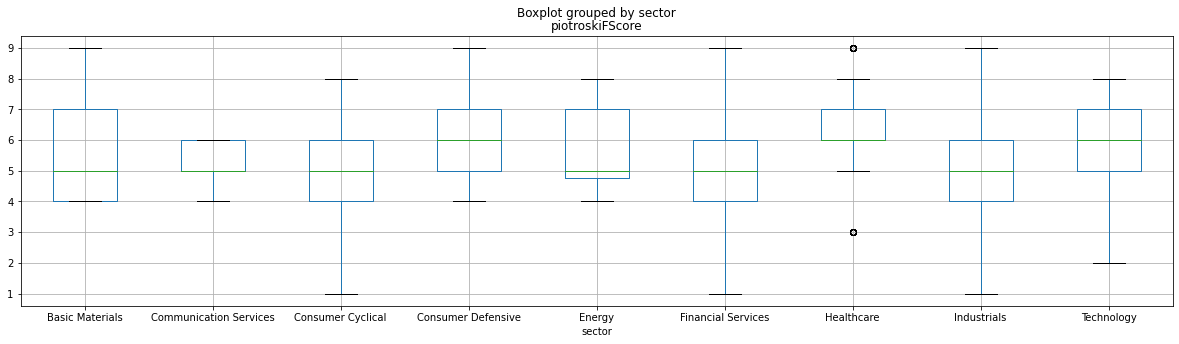

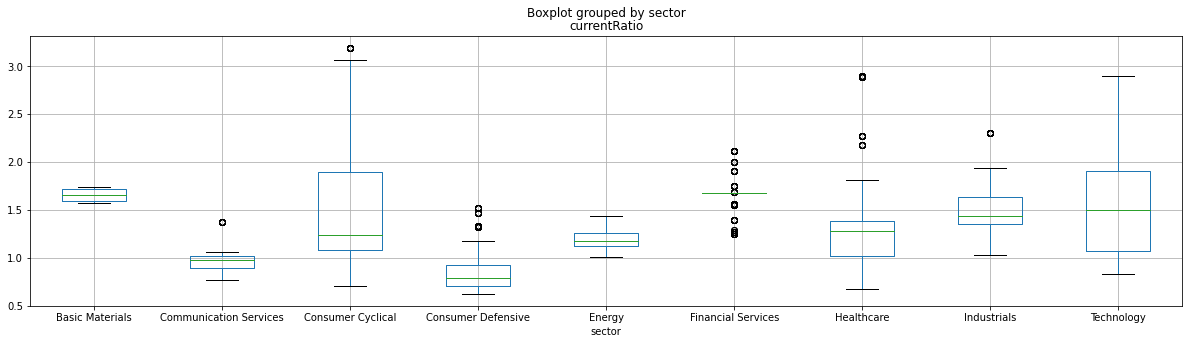

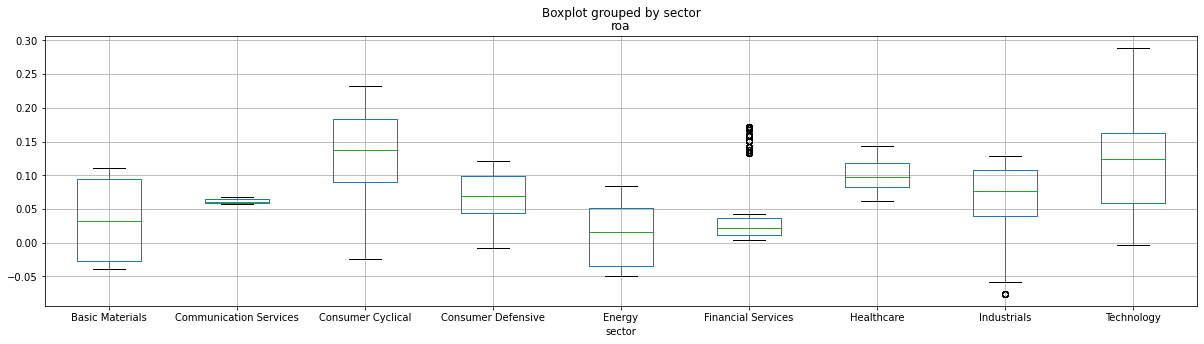

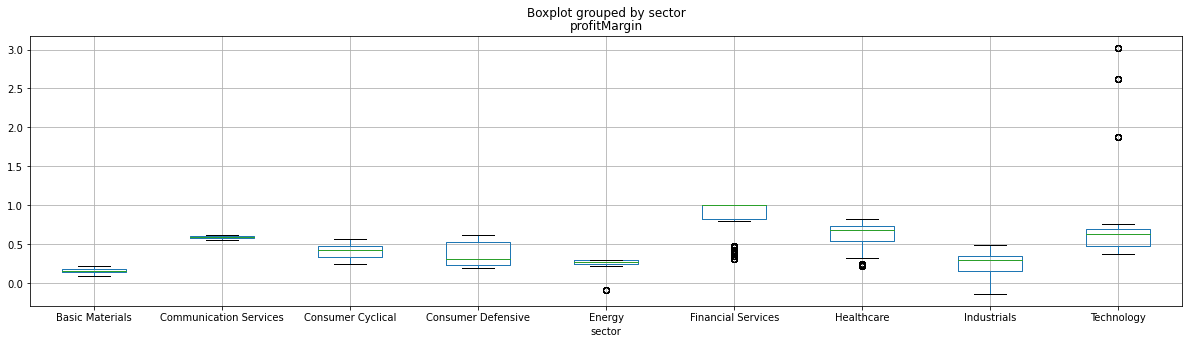

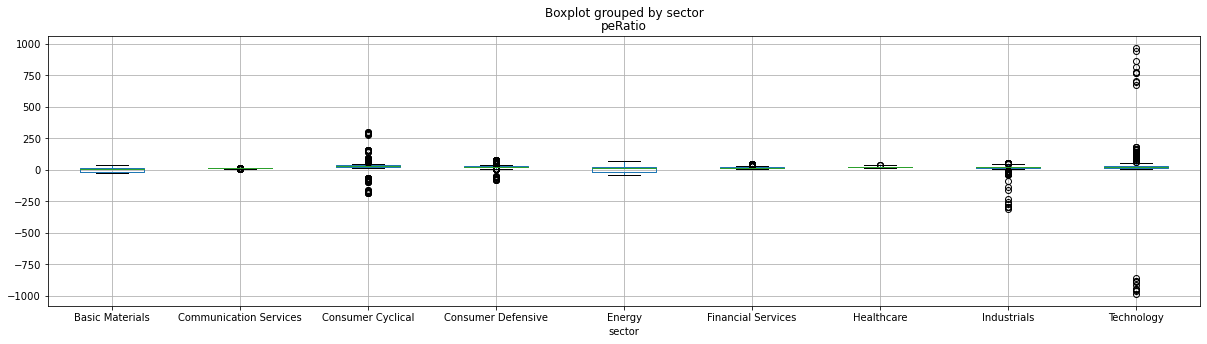

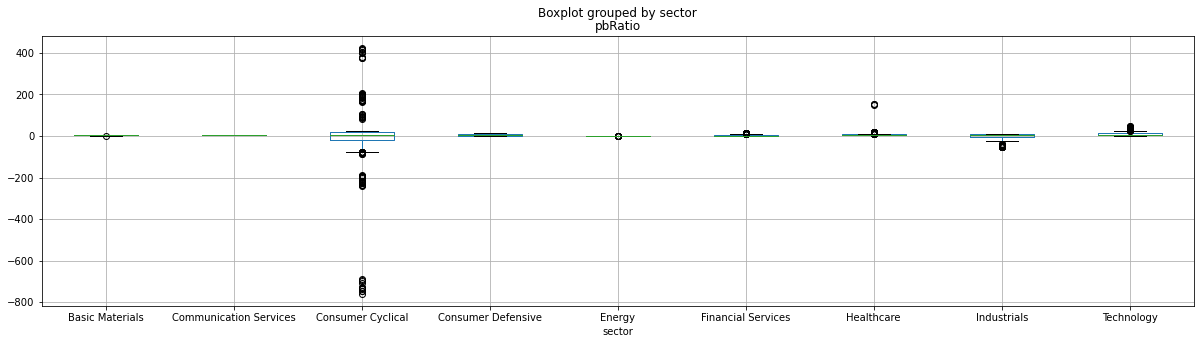

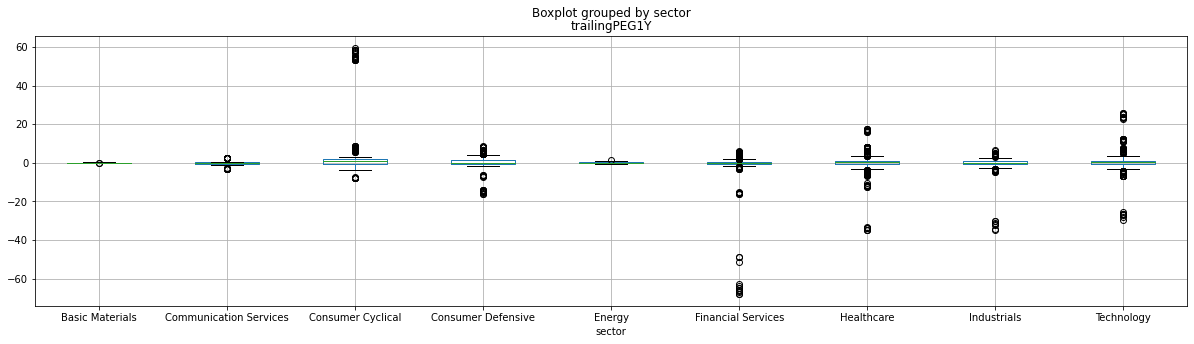

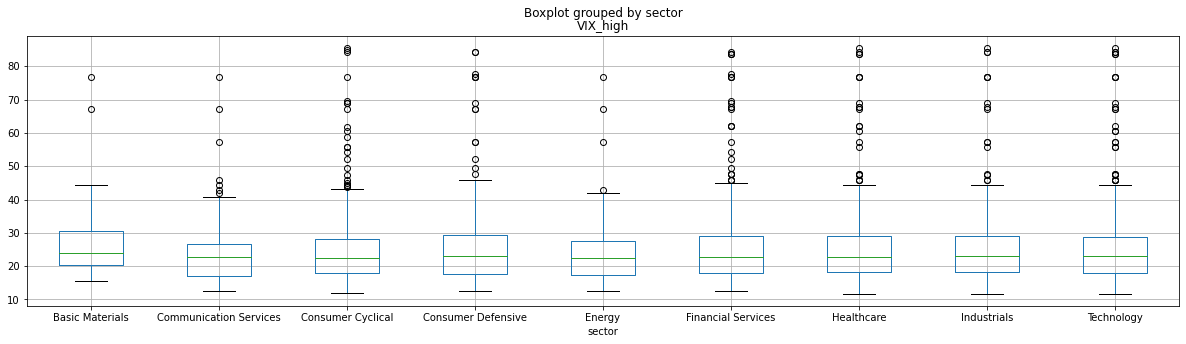

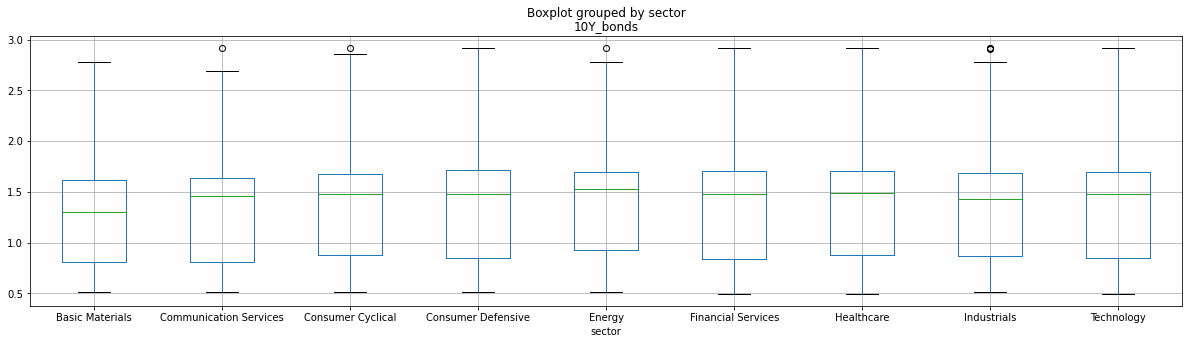

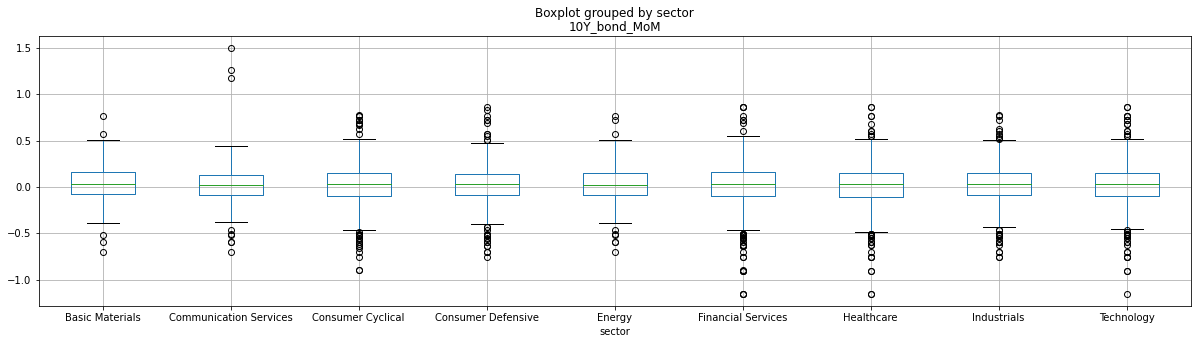

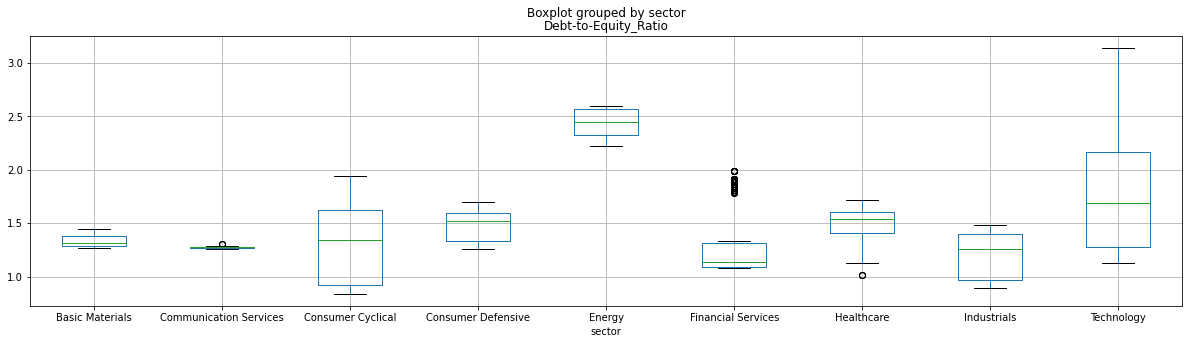

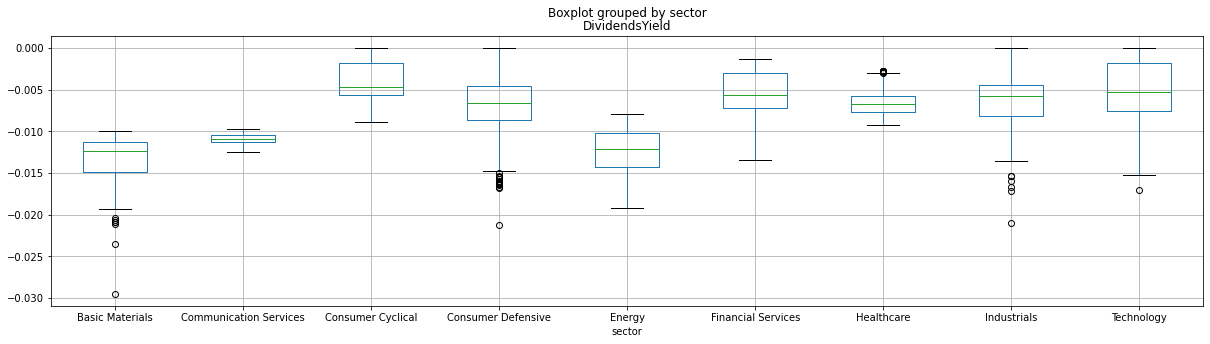

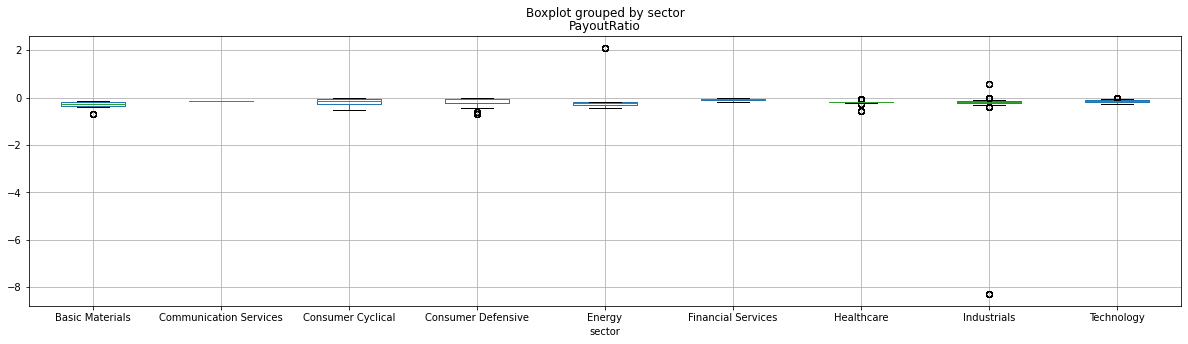

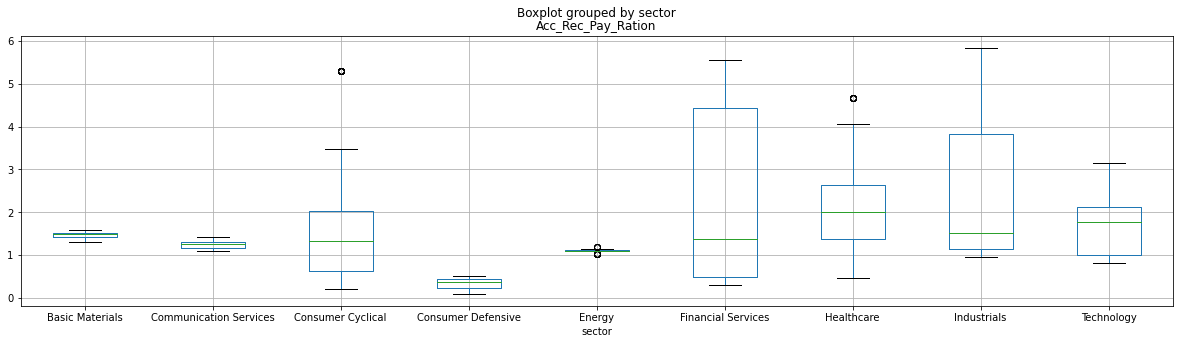

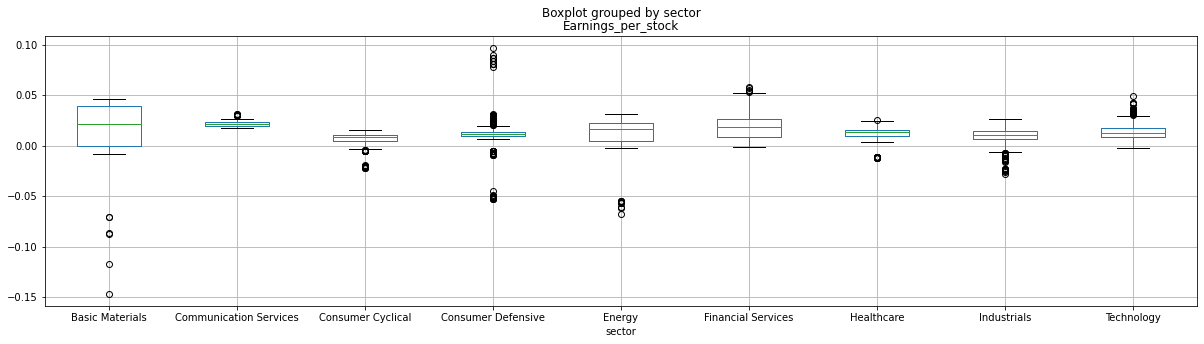

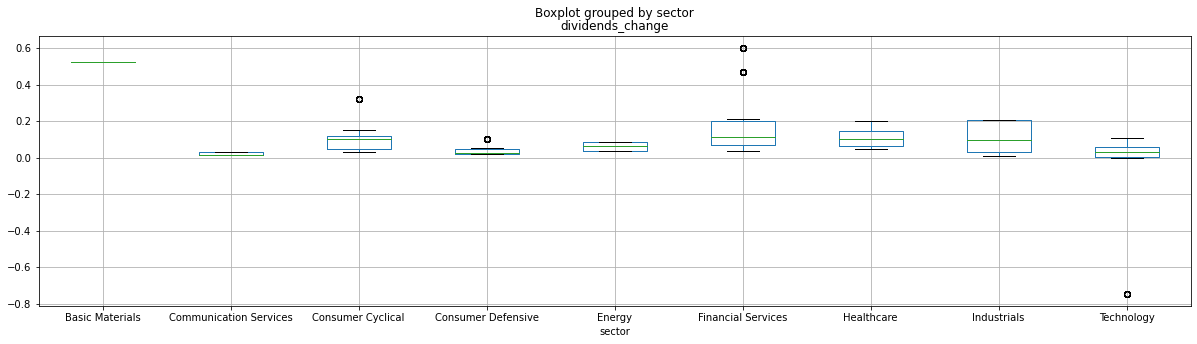

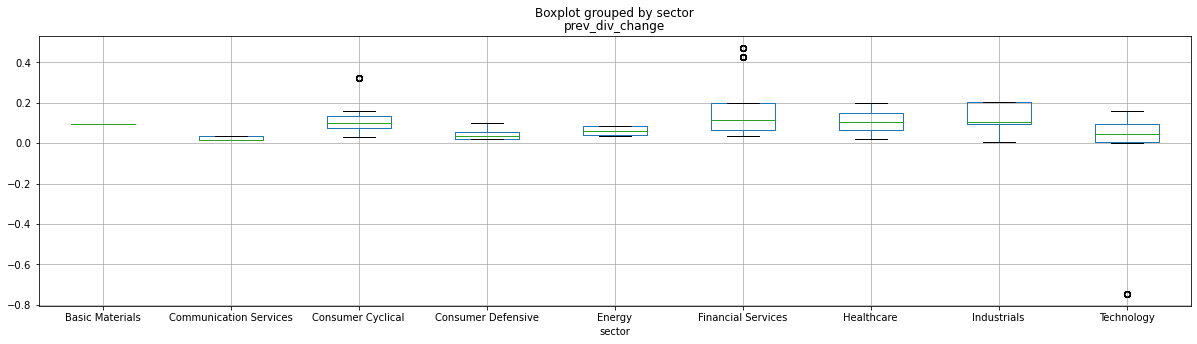

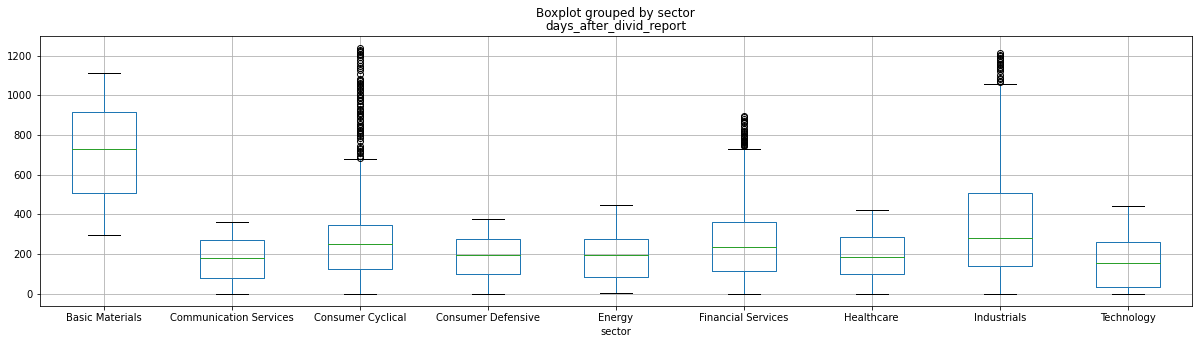

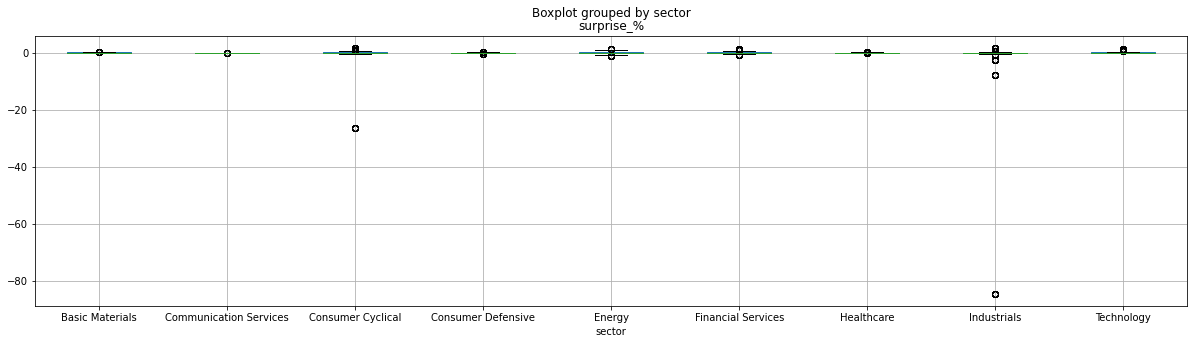

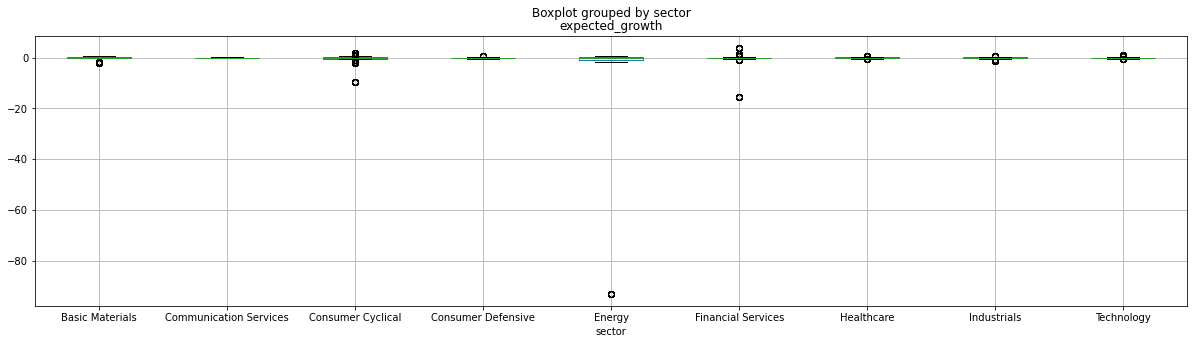

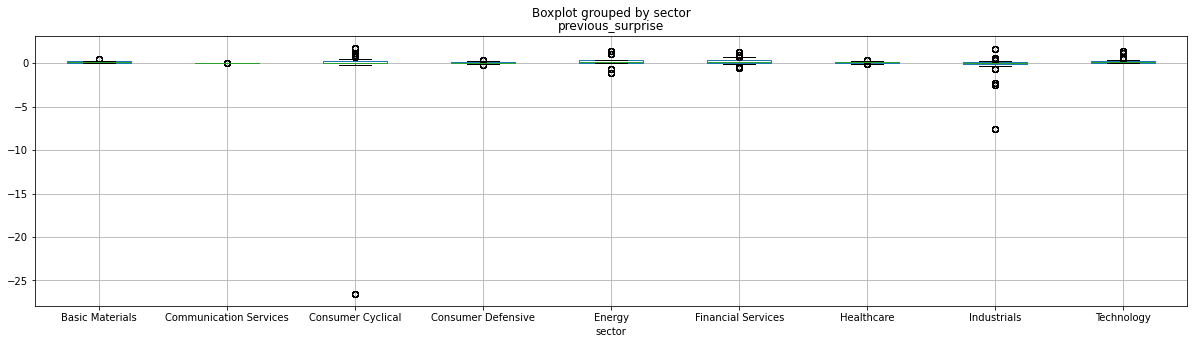

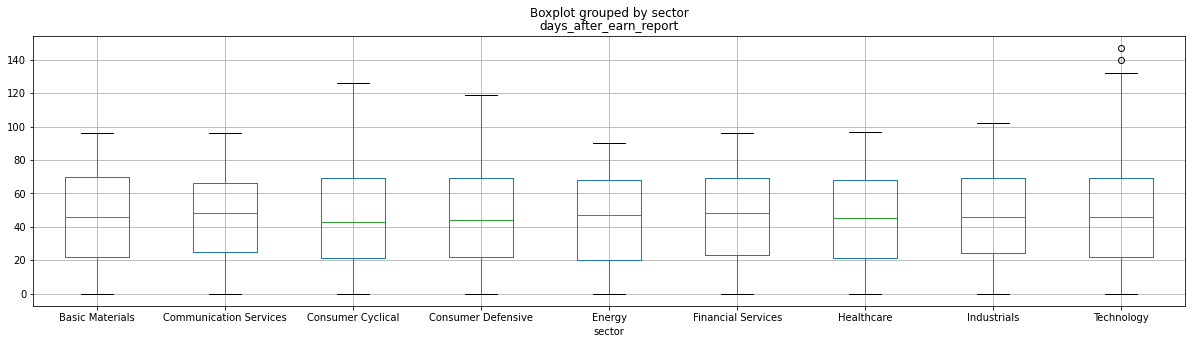

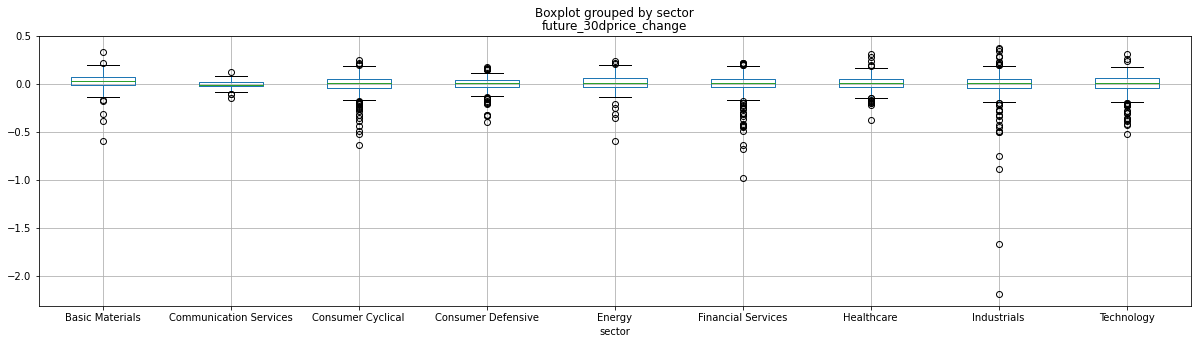

In [30]:
# First we need to select columns that we did not use in outliers replacement
numeric_columns = df_train.select_dtypes(include='number').columns

def create_box_plots(df, columns, by = None, height = 20, width = 10):
    fig, axes = plt.subplots(nrows=len(columns)//2, ncols=2, figsize = (height,width)) # create 2x2 array of subplots

    j = 0
    for col_num, col in enumerate(columns):
        if (col_num % 2) != 0:
            j+=1
        else:
            j = 0
        if by == None:
            df.boxplot(column=col, ax=axes[col_num //2 ,j], figsize = (3,10)); # add boxplot to 1st subplot
        else:
            df.boxplot(column=col, ax=axes[col_num //2 ,j], by = by, figsize = (3,10));

    plt.show()

#create_box_plots(df_train, numeric_columns, "sector", 20,60)
for col in numeric_columns:
    df_train.boxplot(column=col, by = "sector", figsize = (20,5))

Conclusions:
- All of the sectors except for "consumer cyclical" have mostly positive ROE.
- Energy sector has the widest range of quarter over quarter revenue range;
- Basic Materials and Energy sectors have mostly negative earnings per share quarter over quarter growth;
- Companies in Healthcare, Consumer defense and Technology have the highest Piotroski score with a mean of 6 out of 10;
- Companies in the Basic Materials and Financial sectors have the best ratio of current assets to current liabilities
- The highest return on assets is in Technology and Consumer Cyclical sectors
- Companies in Financial Services have the highest profit margin of mean 100%
- Consumer Cyclical has the highest PE_Ratio of 30 while the lowest is in Basic Materials about 3.
- Energy Sector has the worst ratio of Debt to Equity of a mean of 2.3.
- The fastest growth pace showed companies in Healthcare, about 1.3% in a month, while energy has been dropping by 1% a month.

## There are many outliers we would need to treat.

### Let's replace outliers with 3 st.dev values to normalize our data a little

In [31]:
#Before we perform any transformations, we should save a reserve copy of the data
df_train_reserve = df_train.copy()

 Now we need to select columns that we want to "treat".
 We need only columns with wide values distribution that looks like a normal distribution:

In [32]:
columns_to_trim = ['roe', 'revenueQoQ', 'epsQoQ', 'peRatio', 'pbRatio', 'trailingPEG1Y', '10Y_bond_MoM', 'PayoutRatio', 'Earnings_per_stock', 'surprise_%', 'expected_growth', 'previous_surprise', 'future_30dprice_change']

In [33]:
def replace(group):
    mean, std = group.mean(), group.std()
    outliers_max = (group - mean) > 3*std
    outliers_min = (mean - group) > 3*std
    #outliers = (group - mean).abs() > 3*std
    group[outliers_max] = mean + 3*std    
    group[outliers_min] = mean - 3*std    
    return group

df_train[columns_to_trim] = df_train[columns_to_trim].transform(replace)

### This is how our histograms look after the last treatment

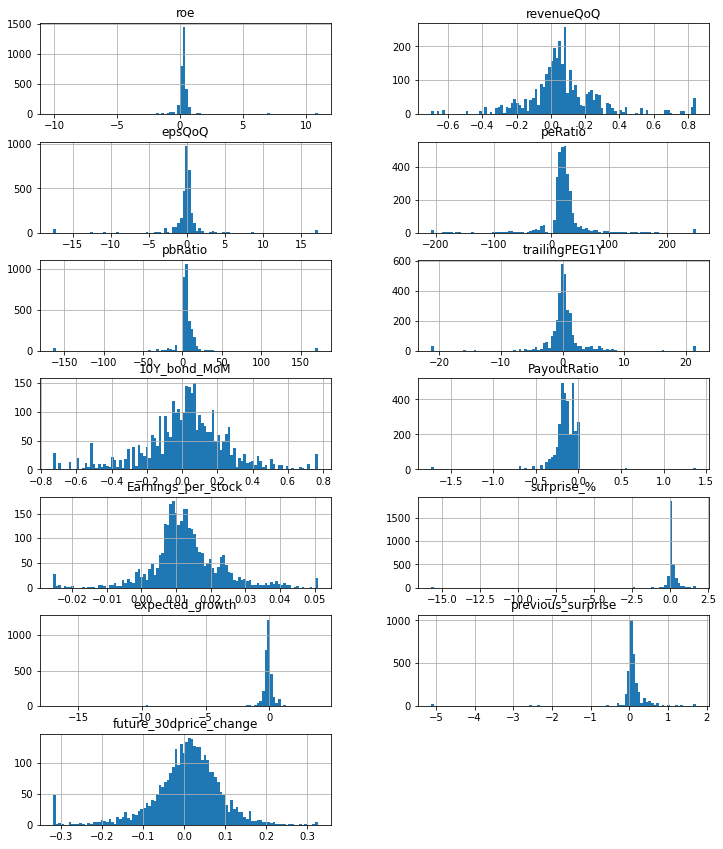

In [34]:
df_train[columns_to_trim].hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

From the first glimpse there are several variables that look like normally distributed.

I am curious if they pass the normal distribution test, let's check

In [35]:
for column in columns_to_trim:
    k2, p = shapiro(df_train[column])
    alpha = 0.005
    if p > alpha:  # null hypothesis: x comes from a normal distribution
        print(f"Column: {column}. Sample looks Gaussian (fail to reject H0). p = {p:g}")
    else:
        print(f"Column: {column}. Sample does not look Gaussian (reject H0). p = {p:g}")

Column: roe. Sample does not look Gaussian (reject H0). p = 0
Column: revenueQoQ. Sample does not look Gaussian (reject H0). p = 4.78361e-41
Column: epsQoQ. Sample does not look Gaussian (reject H0). p = 0
Column: peRatio. Sample does not look Gaussian (reject H0). p = 0
Column: pbRatio. Sample does not look Gaussian (reject H0). p = 0
Column: trailingPEG1Y. Sample does not look Gaussian (reject H0). p = 0
Column: 10Y_bond_MoM. Sample does not look Gaussian (reject H0). p = 1.58822e-26
Column: PayoutRatio. Sample does not look Gaussian (reject H0). p = 0
Column: Earnings_per_stock. Sample does not look Gaussian (reject H0). p = 3.10627e-34
Column: surprise_%. Sample does not look Gaussian (reject H0). p = 0
Column: expected_growth. Sample does not look Gaussian (reject H0). p = 0
Column: previous_surprise. Sample does not look Gaussian (reject H0). p = 0
Column: future_30dprice_change. Sample does not look Gaussian (reject H0). p = 9.98564e-35


As we see from the test above, thou the data looks like normally distributed but it is not actually is so.

 We can see that dealing with outliers helped us to narrow down the distribution.
 
 There are still a number of outliers.
 
 We can replace the outliers by 3 standard deviations once again in an attempt to normalize the data.



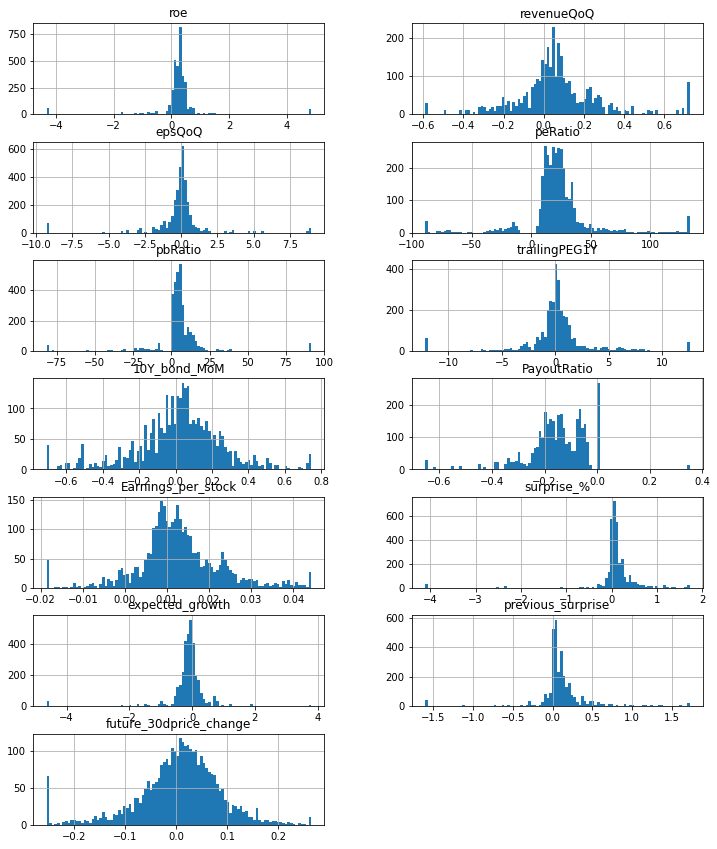

In [36]:
df_train[columns_to_trim] = df_train[columns_to_trim].transform(replace)
df_train[columns_to_trim].hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

Conclusion about outliers treatment (approximate levels):
- ROE max/min level went down from **-10/+55 to -5/+5**
- Revenue QoQ max/min level went down from -1/+2 to -0.8/+0.8
- epsQoQ max/min level went down from -70/+70 to -12/+12
- PE_Ratio max/min level went down from **-1000/+1000 to -70/+150**
- PB_Ratio max/min level went down from **-800/+500 to -80/+100**
- Trailing_PEG max/min level went down from **-80/+70 to -15/+15**
- 10Y_bond_MoM max/min level went down from -1.5/+2 to -0.8/+1.0
- Payout_ratio max/min level went down from -10/+3 to -0.8/+0.5
- Earnings_per_stock max/min level went down from **-0.2/+0.12 to -0.02/+0.05**
- Surprise_% max/min level went down from **-90/+10 to -4/+2**
- Expected_Growth max/min level went down from **-100/+10 to -4/+4**
- Payout_ratio max/min level went down from **-10/+3 to -0.8/+0.5**
- Previous surprise max/min level went down from **-30/+10 to -1.5/+2.0**
- Future_Price_Change max/min level went down from -3/+0.5 to -0.3/+0.4

Let's check if correlation between variables changed after the outliers treatment

In [37]:
check_corr(df_train, 0.35)

column roe correlates with pbRatio : 0.70
column piotroskiFScore correlates with roa : 0.36
column currentRatio correlates with Acc_Rec_Pay_Ration : 0.37
column roa correlates with piotroskiFScore : 0.36
column pbRatio correlates with roe : 0.70
column 10Y_bonds correlates with 10Y_bond_MoM : 0.43
column 10Y_bond_MoM correlates with 10Y_bonds : 0.43
column DividendsYield correlates with PayoutRatio : 0.49
column PayoutRatio correlates with DividendsYield : 0.49
column Acc_Rec_Pay_Ration correlates with currentRatio : 0.37


In [38]:
# We need to reset index from dates because dates have duplicate values
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)

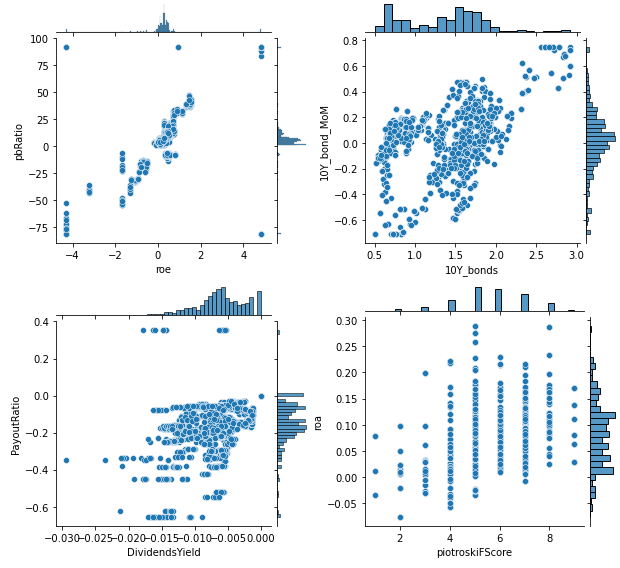

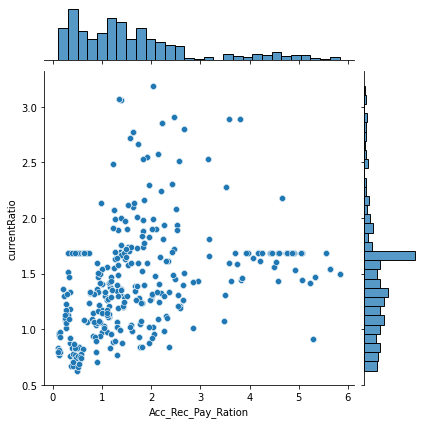

In [39]:
#Visualizing
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(2, 3)

g0 = sns.jointplot(data=df_train, x="roe", y="pbRatio")
g1 = sns.jointplot(data=df_train, x="10Y_bonds", y="10Y_bond_MoM")
g2 = sns.jointplot(data=df_train, x="DividendsYield", y="PayoutRatio")
g3 = sns.jointplot(data=df_train, x="piotroskiFScore", y="roa")
g4 = sns.jointplot(data=df_train, x="Acc_Rec_Pay_Ration", y="currentRatio")


mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])
mg2 = sfg.SeabornFig2Grid(g2, fig, gs[3])
mg3 = sfg.SeabornFig2Grid(g3, fig, gs[2])
mg4 = sfg.SeabornFig2Grid(g3, fig, gs[4])


gs.tight_layout(fig)
#gs.update(top=0.7)

plt.show()

Conclusion:
- There is a strong correlation between the Price/Book Ratio and Returns on Equity with some outliers. 
In general, it shows that companies with higher returns have higher relevant prices per stock.
- Correlation between 10Y bonds and their MoM change shows that high bond yields have a trend to grow quickly. 
At the same time, the amount of data describing the bond's yield above 2.5% is low.
- Slight correlation between Pioroski score and Returns on Assets shows that a company with good financial health doesn't have big debts.

 ## Let's check the data for skewness

In [40]:


columns_we_not_treated = [x for x in list(numeric_columns)  if x not in columns_to_trim]
columns_we_not_treated

['piotroskiFScore',
 'currentRatio',
 'roa',
 'profitMargin',
 'VIX_high',
 '10Y_bonds',
 'Debt-to-Equity_Ratio',
 'DividendsYield',
 'Acc_Rec_Pay_Ration',
 'dividends_change',
 'prev_div_change',
 'days_after_divid_report',
 'days_after_earn_report']

 Now we can check the skewness

In [41]:
def check_skewness(df):
    skewness = df.agg(['skew']).transpose()
    normal_skewness = skewness[(skewness["skew"] < 1) & (skewness["skew"] > -1)]
    normal_skewness_cols = normal_skewness.index.values
    print(f"Columns which values distribution we consider as non skewed: \n{normal_skewness_cols} \n\n")

    bad_right_skewness = skewness[(skewness["skew"] <= -1)]
    bad_right_skewness_cols = bad_right_skewness.index.values
    print(f"Columns that we consider as badly right skewed: \n{bad_right_skewness_cols} \n\n")

    bad_left_skewness = skewness[(skewness["skew"] >= 1)]
    bad_left_skewness_cols = bad_left_skewness.index.values
    print(f"Columns that we consider as badly left skewed: \n{bad_left_skewness_cols} ")
    return normal_skewness_cols, bad_left_skewness_cols, bad_right_skewness_cols

normal_skewness_cols, bad_left_skewness_cols, bad_right_skewness_cols = check_skewness(df_train[columns_we_not_treated])
skewed_columns = np.concatenate((bad_left_skewness_cols, bad_right_skewness_cols), axis=None)

Columns which values distribution we consider as non skewed: 
['piotroskiFScore' 'currentRatio' 'roa' '10Y_bonds' 'DividendsYield'
 'dividends_change' 'days_after_earn_report'] 


Columns that we consider as badly right skewed: 
['prev_div_change'] 


Columns that we consider as badly left skewed: 
['profitMargin' 'VIX_high' 'Debt-to-Equity_Ratio' 'Acc_Rec_Pay_Ration'
 'days_after_divid_report'] 


In [42]:
for col_num, col in enumerate(skewed_columns):
    print(col)

profitMargin
VIX_high
Debt-to-Equity_Ratio
Acc_Rec_Pay_Ration
days_after_divid_report
prev_div_change


In [43]:
#create_box_plots(df_train, skewed_columns)

To bring these columns closer to normal distribution we can use a cubic root

In [44]:
#We can deal with the left skewed columns first
df_train[bad_left_skewness_cols] = np.cbrt(df_train[bad_left_skewness_cols])
#We can check how it looks now
#create_box_plots(df_train, skewed_columns)
#and we need to change it in the test data as well
df_test[bad_left_skewness_cols] = np.cbrt(df_test[bad_left_skewness_cols])

Conclusion:
 - Debt-to-Equity Ratio, Account Receivables to Payables ratio, VIX are looking much better now

### Let's check the skewness again for the columns we treated

In [45]:
normal_skewness_cols, bad_left_skewness_cols, bad_right_skewness_cols = check_skewness(df_train[skewed_columns])

Columns which values distribution we consider as non skewed: 
['Debt-to-Equity_Ratio' 'Acc_Rec_Pay_Ration' 'days_after_divid_report'] 


Columns that we consider as badly right skewed: 
['profitMargin' 'prev_div_change'] 


Columns that we consider as badly left skewed: 
['VIX_high'] 


## ML Part

In [46]:
df_train, df_test = train_test_split(df_compact, test_size=0.2, random_state=42)
df_train.drop(["longTermDebtEquity","grossMargin"], axis = 1, inplace = True)
df_test.drop(["longTermDebtEquity","grossMargin"], axis = 1, inplace = True)

df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)

In [47]:
df_train.drop(["date","stock"], axis = 1, inplace = True)
df_test.drop(["date","stock"], axis = 1, inplace = True)

In [48]:
df.columns

Index(['roe', 'longTermDebtEquity', 'grossMargin', 'revenueQoQ', 'epsQoQ',
       'piotroskiFScore', 'currentRatio', 'roa', 'profitMargin', 'peRatio',
       'pbRatio', 'trailingPEG1Y', 'VIX_high', 'sector', '10Y_bonds',
       '10Y_bond_MoM', 'Debt-to-Equity_Ratio', 'DividendsYield', 'PayoutRatio',
       'Acc_Rec_Pay_Ration', 'Earnings_per_stock', 'dividends_change',
       'prev_div_change', 'days_after_divid_report', 'surprise_%',
       'expected_growth', 'previous_surprise', 'days_after_earn_report',
       'future_30dprice_change', 'stock'],
      dtype='object')

Light GBM can work with categoricl features 8x faster without using OneHotEncoder.
But transforming string to int is still required

In [49]:
le = LabelEncoder()
le.fit(df_train["sector"])
df_train["sector"] = le.transform(df_train["sector"])
df_test["sector"] = le.transform(df_test["sector"])

In [50]:
#Creating the x, y variables 
y_train = df_train['future_30dprice_change']
y_test = df_test['future_30dprice_change']

x_train = df_train.drop('future_30dprice_change', axis = 1)
x_test = df_test.drop('future_30dprice_change', axis = 1)

In [51]:
#Creating a model

In [52]:
lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(n_estimators=50, n_jobs=5, random_state=42)

In [53]:
#predicting on test set
ypred=lgbm.predict(x_test)

In [54]:
#calculating accuracy
from sklearn.metrics import mean_absolute_error as mae
accuracy_lgbm = mae(y_test, ypred)
print(f"Accuracy of prediction:{accuracy_lgbm:0.4f}")

Accuracy of prediction:0.0486


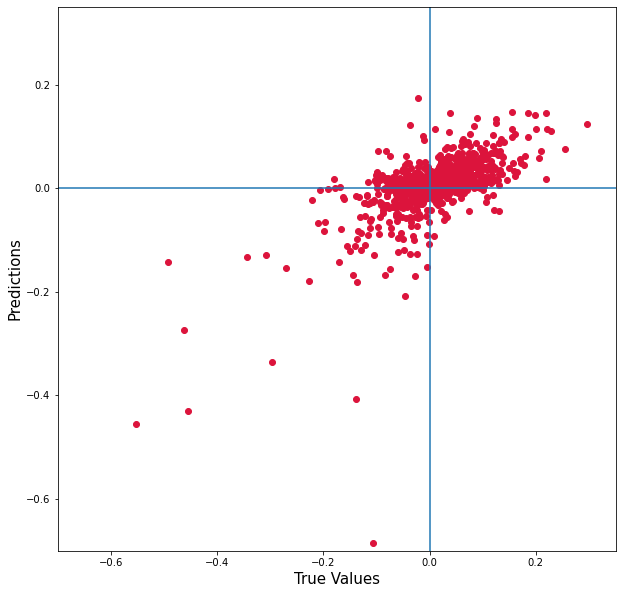

In [55]:
def true_predict_plot(y_val, ypred):
    plt.figure(figsize=(10,10))
    plt.scatter(y_val, ypred, c='crimson')
    plt.yscale('linear')
    plt.xscale('linear')

    p1 = max(max(ypred), max(y_val))
    p2 = min(min(ypred), min(y_val))
    #plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.ylim(-0.7, 0.35)
    plt.xlim(-0.7, 0.35)
    #plt.axis('equal')
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.show()
    
true_predict_plot(y_test, ypred)

In [56]:
df_y_vals = pd.DataFrame()
df_y_vals["Real"] = y_test
df_y_vals["Prediction"] = ypred
df_y_vals["Delta"] = df_y_vals["Real"] - df_y_vals["Prediction"]
df_y_vals["Correct"] = 0
df_y_vals.loc[((df_y_vals['Real'] >0) & (df_y_vals['Prediction'] >0)) | ((df_y_vals['Real'] <0) & (df_y_vals['Prediction'] <0)),'Correct'] = 1

true_false_values = df_y_vals.groupby("Correct").count().Real.to_frame()

true_false_values["Value, %"] = (true_false_values['Real'] / true_false_values['Real'].sum()) * 100
true_false_values["Value, %"] = true_false_values["Value, %"].round(2)
print(true_false_values)

print("\nTotal cases evaluated:",true_false_values.Real.sum())

         Real  Value, %
Correct                
0         208     25.55
1         606     74.45

Total cases evaluated: 814


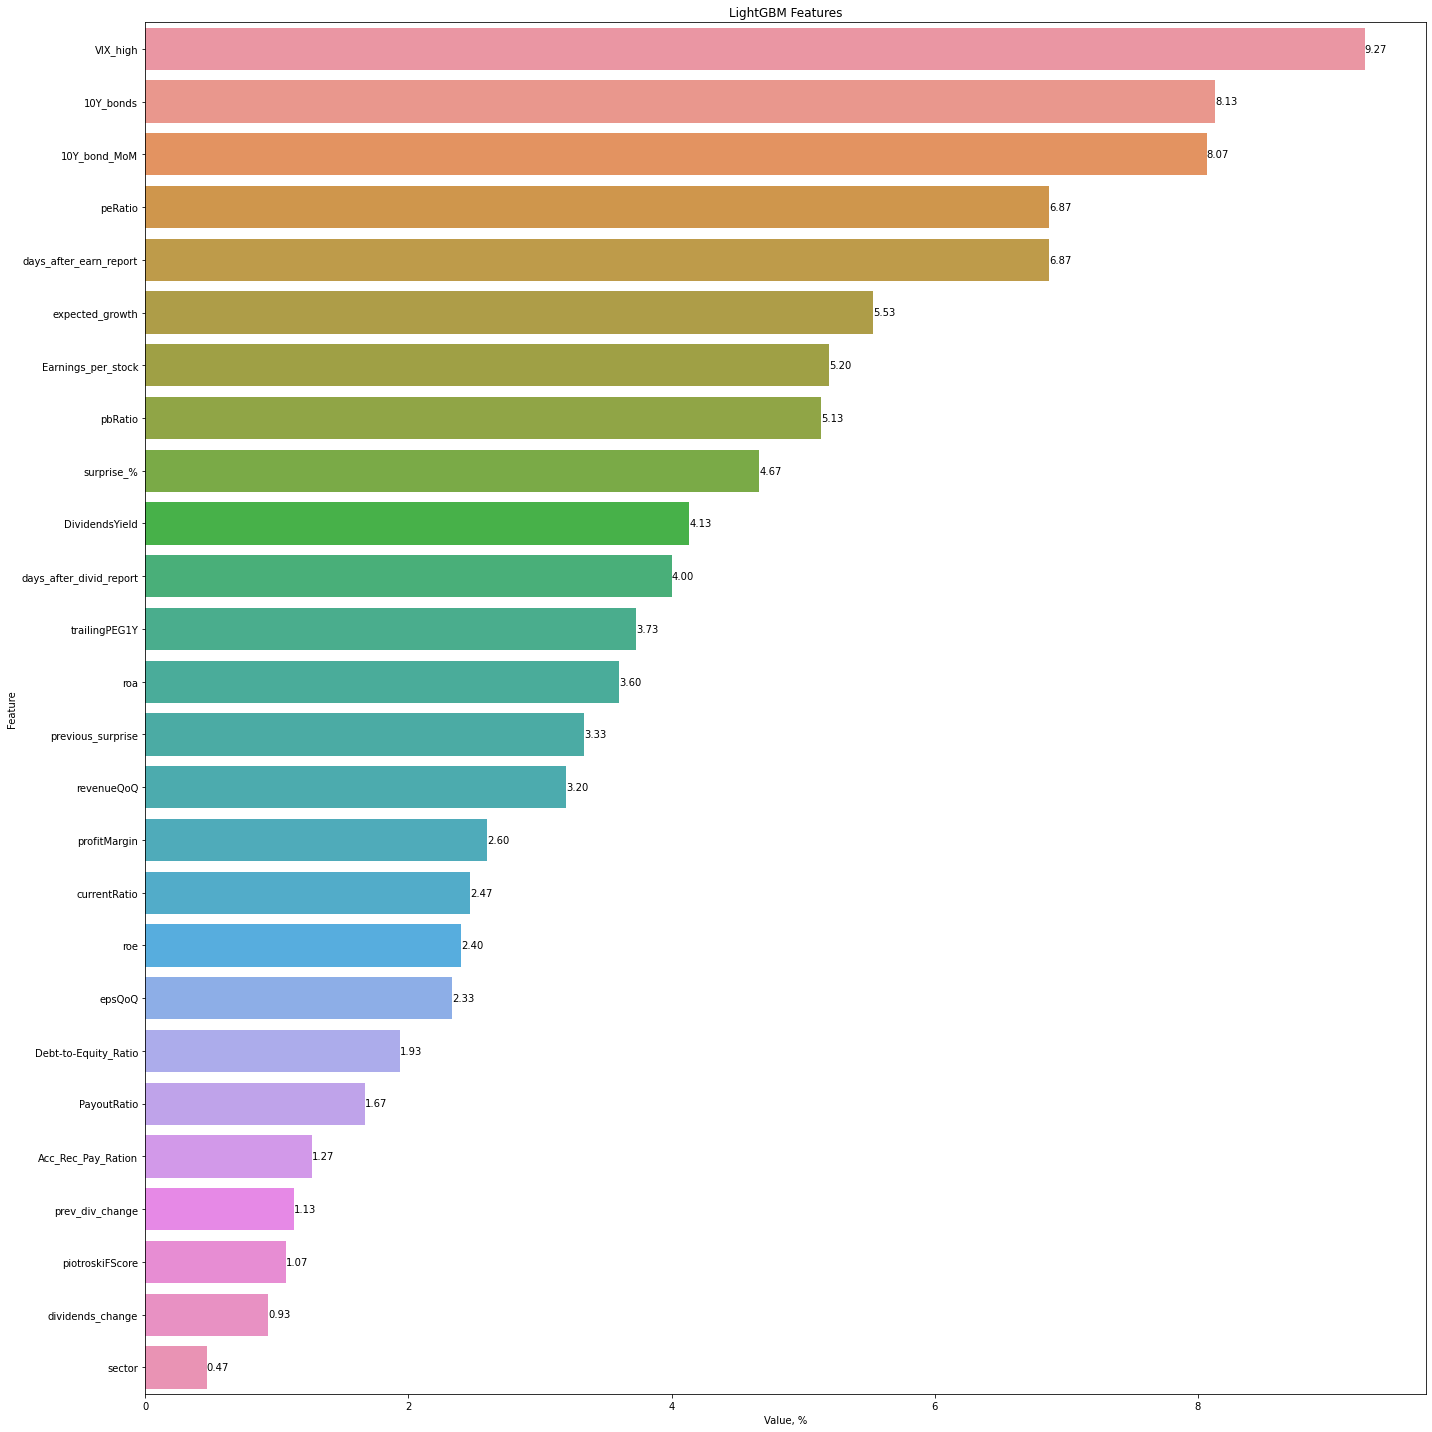

In [58]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100

plt.figure(figsize=(20, 20))
ax = sns.barplot(x="Value, %", y="Feature", data=feature_imp.sort_values(by="Value, %", ascending=False))
ax.bar_label(ax.containers[0], fmt = '%.2f')
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

In [59]:
feature_imp["Value, %"]=feature_imp["Value, %"].round(2)
feature_imp.sort_values(by='Value, %', ascending=False)

,Value,Feature,"Value, %"
25,139,VIX_high,9.27
24,122,10Y_bonds,8.13
23,121,10Y_bond_MoM,8.07
22,103,peRatio,6.87
21,103,days_after_earn_report,6.87
20,83,expected_growth,5.53
19,78,Earnings_per_stock,5.20
18,77,pbRatio,5.13
17,70,surprise_%,4.67
16,62,DividendsYield,4.13


### Save the model as joblib

In [63]:
import joblib
# save the model to disk
filename = 'C:\\Users\\oleg.kazanskyi\\OneDrive - Danaher\\Documents\\Trading Python\\ML_part\\DOW30_LXGB_estim50_jobs5.sav'
joblib.dump(lgbm, filename)

['C:\\Users\\oleg.kazanskyi\\OneDrive - Danaher\\Documents\\Trading Python\\ML_part\\DOW30_LXGB_estim50_jobs5.sav']

In [ ]:
# Grid of parameters to choose from
## add from
lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 10)

parameters = {
    "num_leaves": np.arange(10,150,30),
    "max_depth": [-1,5,10,20],
    'objective':['huber','rmse','mape'],
    "boosting_type":['gbdt', 'rf', 'goss','dart'],
    "learning_rate":[0.00001,0.00003,0.0001],
    "n_estimators": np.arange(50,200,50),
    "n_iter":[100,300,500]
    #"categorical_feature":['sector'],
    #"num_iterations":np.arange(10,300,50),
    #'tree_learner':['serial','feature','data','voting']
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.mean_squared_error)

# Run the grid search
grid_obj = GridSearchCV(lgbm, parameters,scoring=acc_scorer,cv=5)

grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
lgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
lgb_tuned.fit(x_train, y_train)

In [ ]:
#predicting on test set
ypred=lgb_tuned.predict(x_test)

In [ ]:
#calculating accuracy
from sklearn.metrics import mean_absolute_error as mae
accuracy_lgbm = mae(y_test, ypred)
print(f"Accuracy of prediction:{accuracy_lgbm:0.4f}")

In [ ]:
importances = lgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(x_train.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Our model performs terribly so far.

Maybe the crossvalidation will help.

In [ ]:
df_y_vals = pd.DataFrame()
df_y_vals["Real"] = y_test
df_y_vals["Prediction"] = ypred
df_y_vals["Delta"] = df_y_vals["Real"] - df_y_vals["Prediction"]
df_y_vals["Correct"] = 0
df_y_vals.loc[((df_y_vals['Real'] >0) & (df_y_vals['Prediction'] >0)) | ((df_y_vals['Real'] <0) & (df_y_vals['Prediction'] <0)),'Correct'] = 1

true_false_values = df_y_vals.groupby("Correct").count().Real
print(df_y_vals.groupby("Correct").count().Real)

df_y_vals.groupby("Correct").count().Real.sum()